In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 5)

import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load datasets
data_df = pd.read_csv("input/Data 2.csv")
stock_df = pd.read_csv("input/StockPrice.csv")

# Convert Date columns
data_df["Date"] = pd.to_datetime(data_df["Date"])
stock_df["Date"] = pd.to_datetime(stock_df["Date"])

# Sort by date
data_df = data_df.sort_values("Date").reset_index(drop=True)
stock_df = stock_df.sort_values("Date").reset_index(drop=True)

print("Data shape:", data_df.shape)
print("Stock shape:", stock_df.shape)

display(data_df.head())
display(stock_df.head())


Data shape: (3902, 2)
Stock shape: (3839, 2)


,Date,Data
0,2010-01-04,0.700
1,2010-01-05,0.699
2,2010-01-06,0.694
3,2010-01-07,0.692
4,2010-01-08,0.691


,Date,Price
0,2010-01-04,1178.00
1,2010-01-05,1181.50
2,2010-01-06,1182.25
3,2010-01-07,1186.75
4,2010-01-08,1190.75


In [4]:
# Merge on Date
df = pd.merge(stock_df, data_df, on="Date", how="inner")

print("Merged shape:", df.shape)
print("Date range:", df["Date"].min(), "to", df["Date"].max())

display(df.head())


Merged shape: (3802, 3)
Date range: 2010-01-04 00:00:00 to 2025-03-26 00:00:00


,Date,Price,Data
0,2010-01-04,1178.00,0.700
1,2010-01-05,1181.50,0.699
2,2010-01-06,1182.25,0.694
3,2010-01-07,1186.75,0.692
4,2010-01-08,1190.75,0.691


The two input datasets contain a different number of rows due to non-overlapping dates (e.g., missing stock price data on certain days).

An inner join on the Date column was performed to retain only the dates present in both datasets. This ensures that each training sample contains complete information from both sources and avoids introducing missing values or artificial data through imputation

In [5]:
df.info()

print("\nMissing values per column:")
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3802 entries, 0 to 3801
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3802 non-null   datetime64[ns]
 1   Price   3802 non-null   float64       
 2   Data    3802 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 89.2 KB

Missing values per column:


Date     0
Price    0
Data     0
dtype: int64

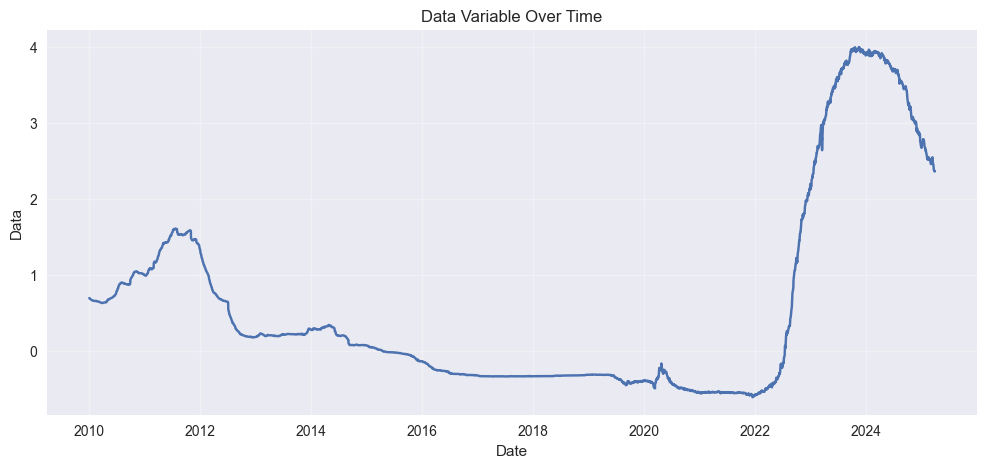

In [6]:
plt.figure()
plt.plot(df["Date"], df["Data"])
plt.title("Data Variable Over Time")
plt.xlabel("Date")
plt.ylabel("Data")
plt.grid(alpha=0.3)
plt.show()


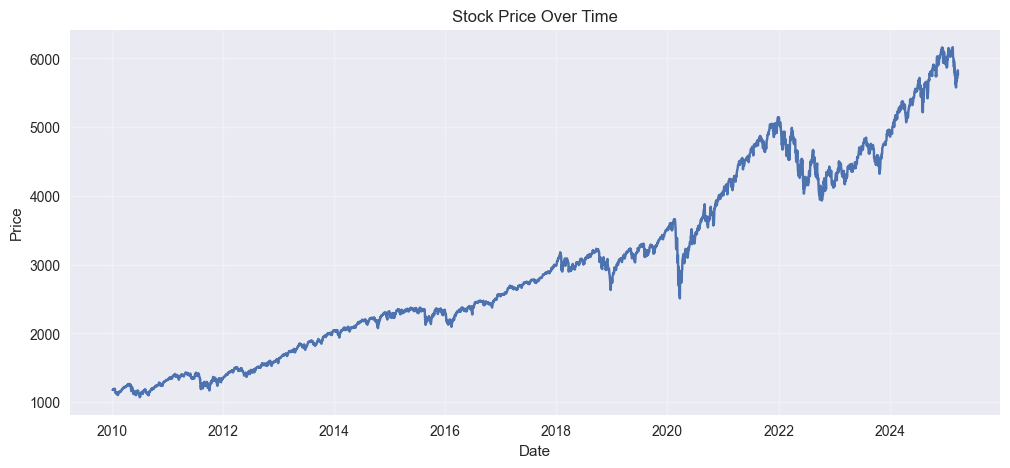

In [7]:
plt.figure()
plt.plot(df["Date"], df["Price"])
plt.title("Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(alpha=0.3)
plt.show()


Both series exhibit temporal dependency and non-stationary behavior, motivating the use of differencing and lag-based features.

In [8]:
df["data_change"] = df["Data"].diff()
df["price_change"] = df["Price"].diff()

display(df[["Date", "Data", "data_change", "Price", "price_change"]].head(10))


,Date,Data,data_change,Price,price_change
0,2010-01-04,0.700,NaN,1178.00,NaN
1,2010-01-05,0.699,-0.001,1181.50,3.50
2,2010-01-06,0.694,-0.005,1182.25,0.75
3,2010-01-07,0.692,-0.002,1186.75,4.50
4,2010-01-08,0.691,-0.001,1190.75,4.00
5,2010-01-11,0.689,-0.002,1191.75,1.00
6,2010-01-12,0.685,-0.004,1183.25,-8.50
7,2010-01-13,0.684,-0.001,1190.75,7.50
8,2010-01-14,0.682,-0.002,1194.50,3.75
9,2010-01-15,0.680,-0.002,1181.50,-13.00


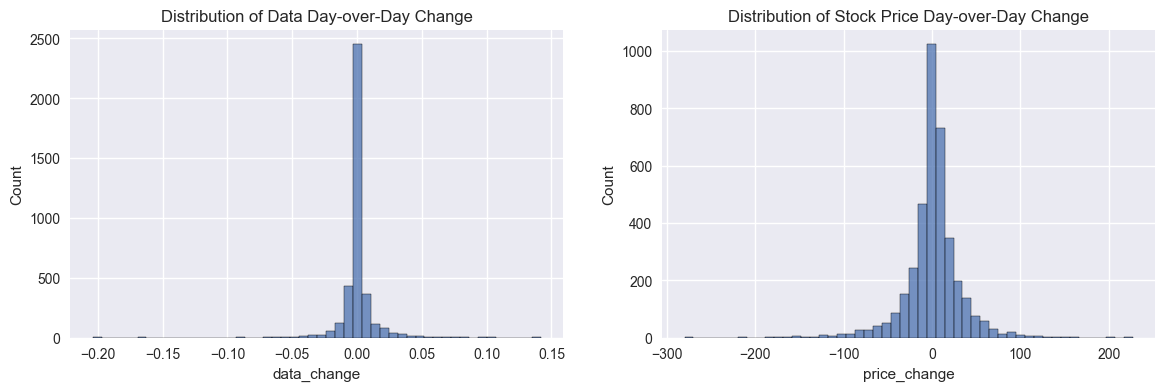

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(df["data_change"].dropna(), bins=50, ax=axes[0])
axes[0].set_title("Distribution of Data Day-over-Day Change")

sns.histplot(df["price_change"].dropna(), bins=50, ax=axes[1])
axes[1].set_title("Distribution of Stock Price Day-over-Day Change")

plt.show()


Day-over-day changes are more centered and stable than raw values, making them more suitable for modeling relationships.

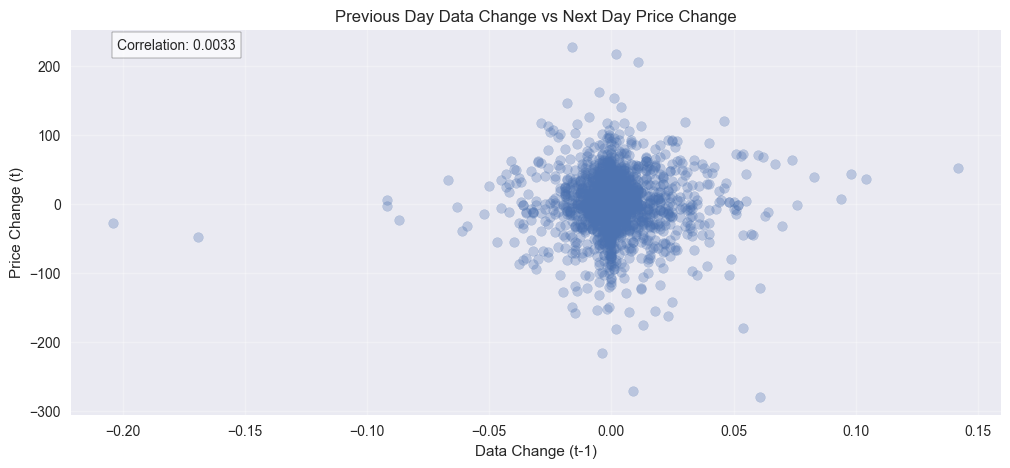

In [10]:
x = df["data_change"].shift(1)
y = df["price_change"]

plt.figure()
plt.scatter(x, y, alpha=0.3)
plt.xlabel("Data Change (t-1)")
plt.ylabel("Price Change (t)")
plt.title("Previous Day Data Change vs Next Day Price Change")
plt.grid(alpha=0.3)

temp = pd.DataFrame({"x": x, "y": y}).dropna()
corr = np.corrcoef(temp["x"], temp["y"])[0, 1]

plt.text(0.05, 0.95, f"Correlation: {corr:.4f}",
         transform=plt.gca().transAxes,
         bbox=dict(facecolor="white", alpha=0.7))

plt.show()


The scatter plot shows a weak linear relationship between the previous day’s change in the Data variable and the next day’s stock price change, with a near-zero correlation coefficient.

This indicates that the influence of Data on stock price is noisy and not strongly linear at a single-day lag. However, the concentration of points around the origin suggests that most daily changes are small, motivating the use of lagged and smoothed features to capture delayed or non-linear effects.
other valid hypothesis
ΔData(t-2)  →  ΔPrice(t)
ΔData(t-3)  →  ΔPrice(t)
mean(ΔData over last 3 days) → ΔPrice(t)


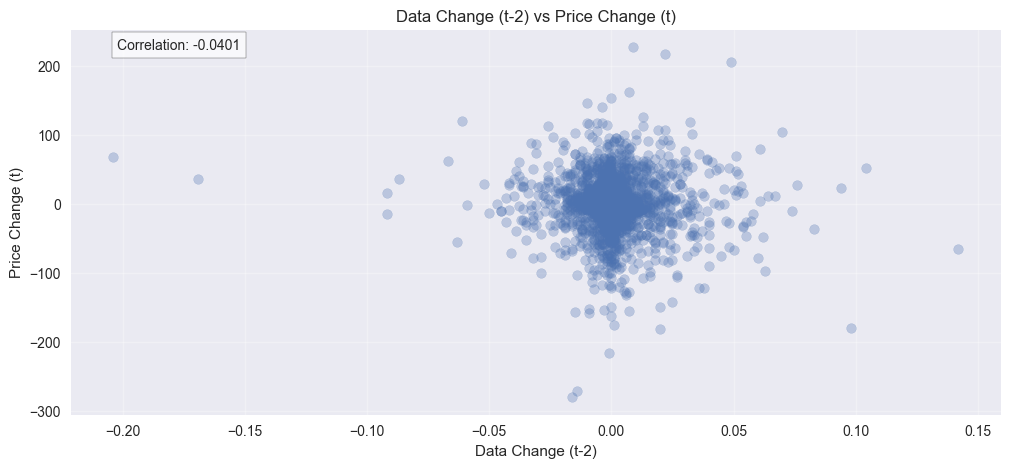

In [11]:
# Lag-2 relationship: Data(t-2) vs Price(t)

x_lag2 = df["data_change"].shift(2)
y = df["price_change"]

plt.figure()
plt.scatter(x_lag2, y, alpha=0.3)
plt.xlabel("Data Change (t-2)")
plt.ylabel("Price Change (t)")
plt.title("Data Change (t-2) vs Price Change (t)")
plt.grid(alpha=0.3)

temp = pd.DataFrame({"x": x_lag2, "y": y}).dropna()
corr_lag2 = np.corrcoef(temp["x"], temp["y"])[0, 1]

plt.text(
    0.05, 0.95,
    f"Correlation: {corr_lag2:.4f}",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="white", alpha=0.7)
)

plt.show()


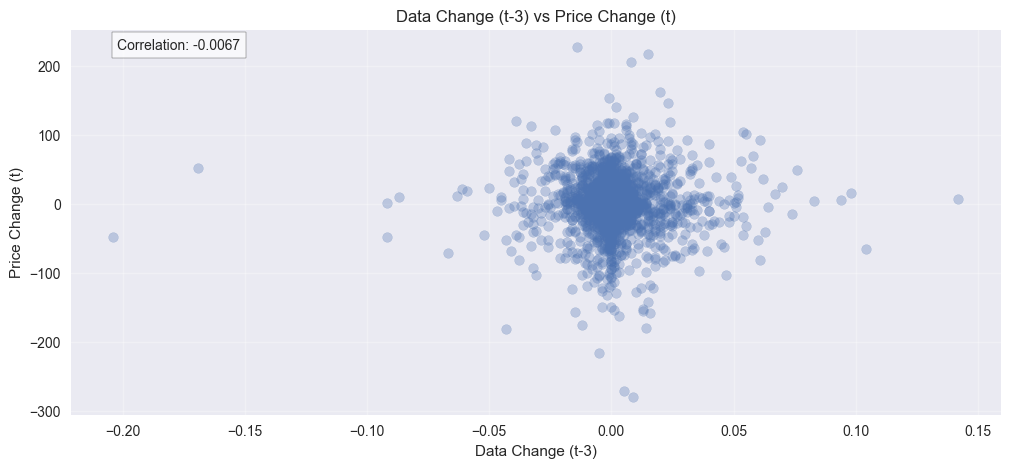

In [12]:
# Lag-3 relationship: Data(t-3) vs Price(t)

x_lag3 = df["data_change"].shift(3)
y = df["price_change"]

plt.figure()
plt.scatter(x_lag3, y, alpha=0.3)
plt.xlabel("Data Change (t-3)")
plt.ylabel("Price Change (t)")
plt.title("Data Change (t-3) vs Price Change (t)")
plt.grid(alpha=0.3)

temp = pd.DataFrame({"x": x_lag3, "y": y}).dropna()
corr_lag3 = np.corrcoef(temp["x"], temp["y"])[0, 1]

plt.text(
    0.05, 0.95,
    f"Correlation: {corr_lag3:.4f}",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="white", alpha=0.7)
)

plt.show()


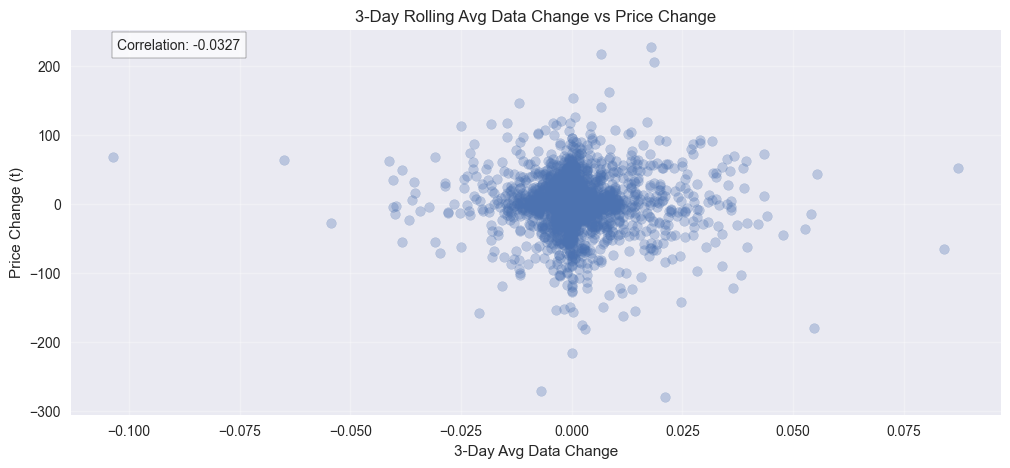

In [13]:
# Rolling 3-day average of Data change vs Price change

df["data_change_ma3"] = df["data_change"].rolling(3).mean()

x_ma3 = df["data_change_ma3"]
y = df["price_change"]

plt.figure()
plt.scatter(x_ma3, y, alpha=0.3)
plt.xlabel("3-Day Avg Data Change")
plt.ylabel("Price Change (t)")
plt.title("3-Day Rolling Avg Data Change vs Price Change")
plt.grid(alpha=0.3)

temp = pd.DataFrame({"x": x_ma3, "y": y}).dropna()
corr_ma3 = np.corrcoef(temp["x"], temp["y"])[0, 1]

plt.text(
    0.05, 0.95,
    f"Correlation: {corr_ma3:.4f}",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="white", alpha=0.7)
)

plt.show()


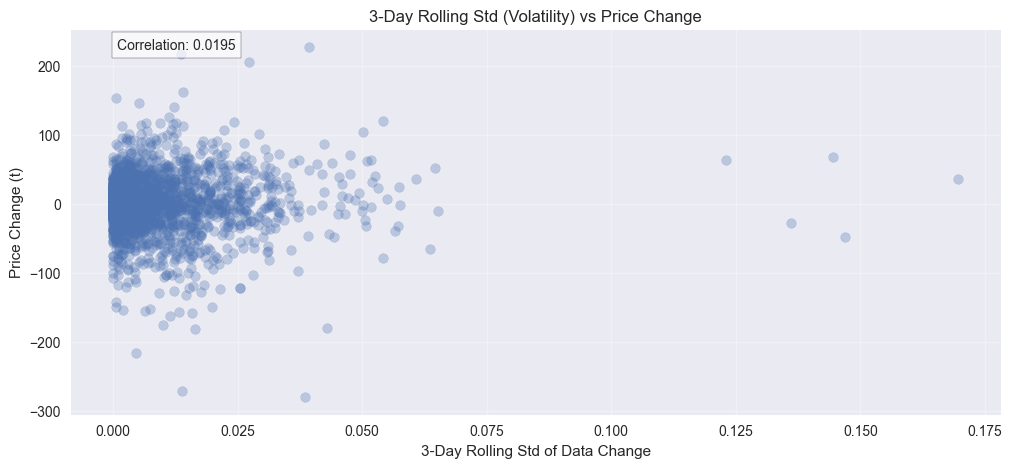

In [14]:
# Rolling 3-day standard deviation of Data change vs Price change

df["data_change_std3"] = df["data_change"].rolling(3).std()

x_std3 = df["data_change_std3"]
y = df["price_change"]

plt.figure()
plt.scatter(x_std3, y, alpha=0.3)
plt.xlabel("3-Day Rolling Std of Data Change")
plt.ylabel("Price Change (t)")
plt.title("3-Day Rolling Std (Volatility) vs Price Change")
plt.grid(alpha=0.3)

temp = pd.DataFrame({"x": x_std3, "y": y}).dropna()
corr_std3 = np.corrcoef(temp["x"], temp["y"])[0, 1]

plt.text(
    0.05, 0.95,
    f"Correlation: {corr_std3:.4f}",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="white", alpha=0.7)
)

plt.show()


In [28]:
# Create modeling features (based on EDA conclusions)

model_df = df.copy()

# Lagged data changes
model_df["data_change_lag1"] = model_df["data_change"].shift(1)
model_df["data_change_lag2"] = model_df["data_change"].shift(2)
model_df["data_change_lag3"] = model_df["data_change"].shift(3)

# Rolling statistics
model_df["data_change_ma3"] = model_df["data_change"].rolling(3).mean()
model_df["data_change_ma7"] = model_df["data_change"].rolling(7).mean()

# Optional: minimal price memory (stability, not causation)
model_df["price_lag1"] = model_df["Price"].shift(1)
model_df["price_change_lag1"] = model_df["price_change"].shift(1)

# Target variable
model_df["target"] = model_df["Price"].shift(-1)
model_df = model_df.dropna().reset_index(drop=True)


model_df.head(10)


,Date,Price,Data,data_change,price_change,data_change_ma3,data_change_std3,data_change_lag1,data_change_lag2,data_change_lag3,data_change_ma7,price_lag1,price_change_lag1,target
0,2010-01-13,1190.75,0.684,-0.001,7.50,-0.002333,0.001528,-0.004,-0.002,-0.001,-0.002286,1183.25,-8.50,1194.50
1,2010-01-14,1194.50,0.682,-0.002,3.75,-0.002333,0.001528,-0.001,-0.004,-0.002,-0.002429,1190.75,7.50,1181.50
2,2010-01-15,1181.50,0.680,-0.002,-13.00,-0.001667,0.000577,-0.002,-0.001,-0.004,-0.002000,1194.50,3.75,1195.00
3,2010-01-19,1195.00,0.675,-0.005,13.50,-0.003000,0.001732,-0.002,-0.002,-0.001,-0.002429,1181.50,-13.00,1183.25
4,2010-01-20,1183.25,0.674,-0.001,-11.75,-0.002667,0.002082,-0.005,-0.002,-0.002,-0.002429,1195.00,13.50,1160.25
5,2010-01-21,1160.25,0.672,-0.002,-23.00,-0.002667,0.002082,-0.001,-0.005,-0.002,-0.002429,1183.25,-11.75,1140.25
6,2010-01-22,1140.25,0.670,-0.002,-20.00,-0.001667,0.000577,-0.002,-0.001,-0.005,-0.002143,1160.25,-23.00,1141.75
7,2010-01-25,1141.75,0.669,-0.001,1.50,-0.001667,0.000577,-0.002,-0.002,-0.001,-0.002143,1140.25,-20.00,1136.50
8,2010-01-26,1136.50,0.667,-0.002,-5.25,-0.001667,0.000577,-0.001,-0.002,-0.002,-0.002143,1141.75,1.50,1143.75
9,2010-01-27,1143.75,0.665,-0.002,7.25,-0.001667,0.000577,-0.002,-0.001,-0.002,-0.002143,1136.50,-5.25,1128.50


Initial correlation analysis showed weak linear relationships between engineered features and the target variable. However, correlation only captures linear dependency and may fail to detect non-linear signals commonly present in financial time-series data.

To address this limitation, Mutual Information (MI) was used to measure both linear and non-linear dependencies between features and the target.

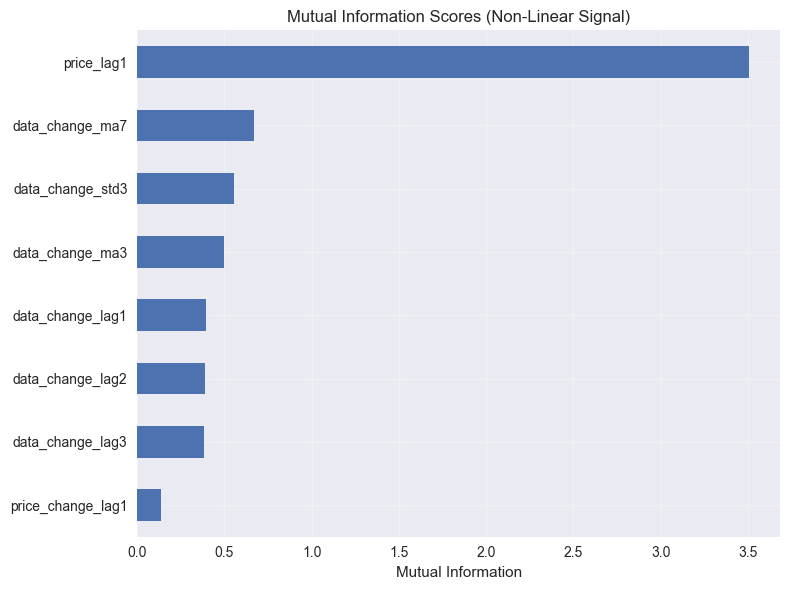

price_change_lag1    0.136903
data_change_lag3     0.385553
data_change_lag2     0.388047
data_change_lag1     0.395561
data_change_ma3      0.500030
data_change_std3     0.553008
data_change_ma7      0.670321
price_lag1           3.508276
dtype: float64

In [29]:
from sklearn.feature_selection import mutual_info_regression

# -------------------------------
# Mutual Information Analysis
# -------------------------------

# Select feature columns used in modeling
mi_features = [
    "data_change_lag1",
    "data_change_lag2",
    "data_change_lag3",
    "data_change_ma3",
    "data_change_ma7",
    "data_change_std3",
    "price_lag1",
    "price_change_lag1"
]

X_mi = model_df[mi_features]
y_mi = model_df["target"]

# Compute Mutual Information scores
mi_scores = mutual_info_regression(
    X_mi,
    y_mi,
    random_state=42
)

# Create sorted series
mi_results = (
    pd.Series(mi_scores, index=mi_features)
    .sort_values()
)

# Plot
plt.figure(figsize=(8, 6))
mi_results.plot(kind="barh")
plt.title("Mutual Information Scores (Non-Linear Signal)")
plt.xlabel("Mutual Information")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Display values as table
mi_results


While linear correlation analysis indicated weak relationships between individual features and the target variable, Mutual Information (MI) analysis revealed non-zero non-linear dependencies across several engineered features.

The strongest dependency was observed for the previous-day stock price, confirming strong price autocorrelation. Among external data features, rolling statistics showed higher MI scores than raw or lagged daily changes. In particular, the 7-day rolling average exhibited the highest MI, suggesting that the market responds more to sustained weekly trends rather than isolated daily movements.

Short-term volatility of the external data (3-day rolling standard deviation) also showed meaningful dependency, indicating that periods of higher uncertainty may influence next-day price behavior. Individual lagged data changes contributed moderate but similar MI scores, implying that their effects are distributed over time and largely captured by rolling trend features.

Based on these observations, the final feature set prioritizes price autocorrelation, short- and medium-term data trends, and volatility, while removing redundant lag features to reduce multicollinearity and improve generalization.

## Regime Shift Analysis (Stability of Relationship Over Time)


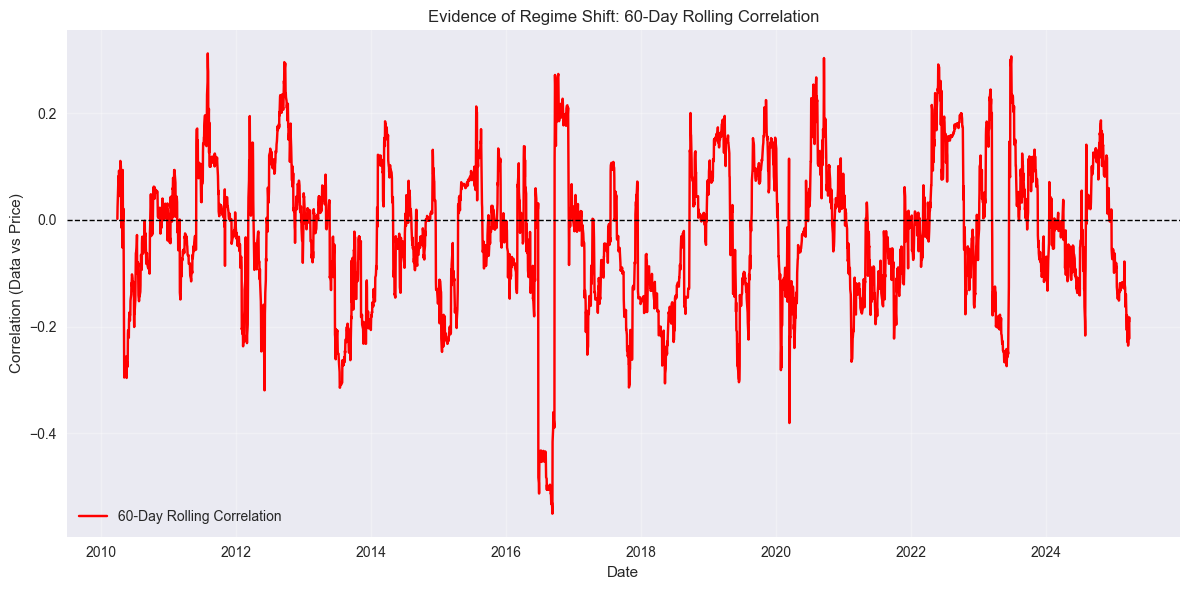

In [30]:
# ----------------------------------------
# Regime Shift Analysis: Rolling Correlation
# ----------------------------------------

plt.figure(figsize=(12, 6))

rolling_corr = (
    df["Data"]
    .pct_change()
    .rolling(window=60)
    .corr(df["Price"].pct_change())
)

plt.plot(df["Date"], rolling_corr, color="red", label="60-Day Rolling Correlation")
plt.axhline(0, color="black", linestyle="--", linewidth=1)

plt.title("Evidence of Regime Shift: 60-Day Rolling Correlation")
plt.xlabel("Date")
plt.ylabel("Correlation (Data vs Price)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


**Observation:**
The 60-day rolling correlation between Data changes and Price changes fluctuates significantly over time and frequently crosses zero.

**Conclusion:**
This indicates regime shifts in market behavior, where the influence of Data on Price is unstable and time-dependent.

**Modeling Implication:**
Feature engineering focuses on lagged and rolling statistics rather than direct correlation, allowing the model to learn delayed and distributed signals across changing regimes.
